# Extract Relative Pose
This script is used to convert ground truth scripts with absolute poses to relative poses for RPR

In [1]:
import numpy as np
import os
from scipy.spatial.transform import Rotation as R

In [16]:
data_root = 'D:/Imperial/FYP/captured_data/airsim_drone_mode/building_v4'
split = "train"
seq_dict = {'val': 'seq-01', 'train': 'seq-02'}
poses, ims = [], []
with open(os.path.join(data_root, seq_dict[split], 'airsim_rec.txt'), 'r') as f:
	for line in f.readlines()[1::]:
		cur = line.split('\t')
		xyz = np.array([float(v) for v in cur[2:5]], dtype=np.float32)
		wxyz = np.array([float(v) for v in cur[5:9]], dtype=np.float32)
		poses.append((xyz,wxyz))
		ims.append(f"/{seq_dict[split]}/images/" + cur[-1].strip('\n'))

## Calculate Relative Poses

In [17]:
skip = 5
relative_poses = []

def obtain_relative_pose(absolute_pose_c1, absolute_pose_c2):
	xyz1, wxyz1 = absolute_pose_c1[:3], absolute_pose_c1[3:]
	xyz2, wxyz2 = absolute_pose_c2[:3], absolute_pose_c2[3:]

	# Airsim records quartenion as wxyz but scipy takes in xyzw format
	rot_mat1 = R.from_quat(np.hstack([wxyz1[1:], wxyz1[0]])).as_matrix()
	rot_mat2 = R.from_quat(np.hstack([wxyz2[1:], wxyz2[0]])).as_matrix()

	# Obtain Relative poses
	relative_t = xyz2 - xyz1 
	relative_q = R.from_matrix(np.matmul(np.transpose(rot_mat1), rot_mat2)).as_quat()
	relative_q = np.hstack([relative_q[3:], relative_q[:3]]) # Convert to wxyz format

	return relative_t, relative_q

for i in range(len(poses) - skip):
	relative_t, relative_q = obtain_relative_pose(np.hstack(poses[i]), np.hstack(poses[i+ skip]))	
	relative_poses.append(np.hstack([relative_t, relative_q]))

## Check Distribution

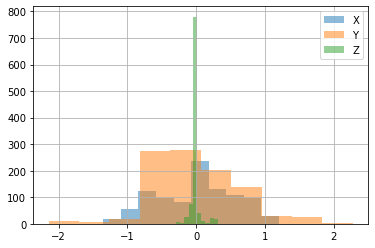

In [18]:
import matplotlib.pyplot as plt

plt.hist(np.vstack(relative_poses)[:,0], label="X", alpha=0.5)
plt.hist(np.vstack(relative_poses)[:,1], label="Y", alpha=0.5)
plt.hist(np.vstack(relative_poses)[:,2], label="Z", alpha=0.5)
plt.legend()
plt.grid()

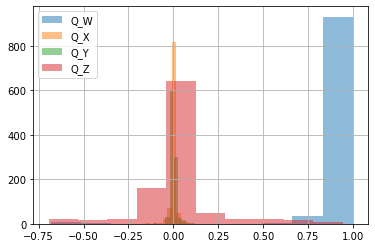

In [19]:
plt.hist(np.vstack(relative_poses)[:,3], label="Q_W", alpha=0.5)
plt.hist(np.vstack(relative_poses)[:,4], label="Q_X", alpha=0.5)
plt.hist(np.vstack(relative_poses)[:,5], label="Q_Y", alpha=0.5)
plt.hist(np.vstack(relative_poses)[:,6], label="Q_Z", alpha=0.5)
plt.legend()
plt.grid()

## Write to text file

In [15]:
with open(os.path.join('.','assets','data', f'{split}.txt'), 'w') as f:
	for i in range(0, len(relative_poses)-skip):
		f.writelines(f"{ims[i]} {ims[i+skip]} {relative_poses[i][0]:.6f} {relative_poses[i][1]:.6f} {relative_poses[i][2]:.6f} {relative_poses[i][3]:.6f} {relative_poses[i][4]:.6f} {relative_poses[i][5]:.6f} {relative_poses[i][6]:.6f}\n")

## Check Reverse Calculation to obtain absolute pose

In [ ]:
def obtain_absolute_pose(absolute_pose_c2, relative_pose):
	xyz2, wpqr2 = absolute_pose_c2[:3], absolute_pose_c2[3:]
	xyz_rel, wpqr_rel = relative_pose[:3], relative_pose[3:]
	rot_mat2 = R.from_quat(np.hstack([wpqr2[1:], wpqr2[0]])).as_matrix()
	rot_mat_rel = R.from_quat(np.hstack([wpqr_rel[1:], wpqr_rel[0]])).as_matrix()
	t1 = xyz2 - xyz_rel 
	r1 = R.from_matrix(np.matmul(rot_mat2,np.linalg.inv(rot_mat_rel))).as_quat()
	r1 = np.hstack([r1[3:], r1[:3]])
	return t1, r1

pos = 0
print(ims[pos], ims[pos + skip])
print(f"relative poses {relative_poses[pos]}")
print(f"absolute pose for img 1 {poses[pos]}\nabsolute pose for img2 {poses[pos+skip]}")

print(obtain_absolute_pose(np.hstack(poses[pos+skip]), relative_poses[pos]))
